# Lab 1: Neural Networks
This week, you will use EEG recording of one patient with epileptic seizures to train a fully-connected neural network and a convolutional neural network. You can use this link https://keras.io/api/ to get more information about how to work with keras.

## A: Data pre-processing
We first load all python packages required for the code. In principle, these are all packages you will need for this lab, so **you’re not allowed** to import any other packages besides the ones we provide you with.

#### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import keras as keras, nn
import pandas as pd
from scipy.io import loadmat

Now, we load the dataset. This is an EEG recording of one patient with epilepsy with annotator labels. A label 1 means that the patient had an epileptic seizure in that fragment of the data, label 0 means that the patient did not have an epileptic seizure. The patient's EEG was recorded with 4 simultaneous EEG electrodes, similar to the E-Glass set-up, resulting in 2 differential EEG signals of 1024 samples each.


In the code below, you'll be provided with 'data', 'label' and 'test_data'. The 'data' and 'label' are the dataset that you will use to train and validate neural networks. At the end of the lab, you will use your trained convolutional neural network to predict the labels of 'test_data'. When you hand in the lab, your predicted labels will be compared against a set of secret annotator labels by Kaggle.

#### Import data

In [2]:
filepath = '../input/machine-learning-for-iot-2023-ht-lab-1/patient_08.mat'
data = loadmat(filepath)['dataset']
label = loadmat(filepath)['label']
test_data = loadmat(filepath)['train_dataset']

print('shape of train and validation data vector: ',np.shape(data))
print('shape of annotator labels: ',np.shape(label))
print('shape of test data vector: ',np.shape(test_data))

shape of train and validation data vector:  (268, 2048)
shape of annotator labels:  (268, 1)
shape of test data vector:  (200, 2048)


#### Split the dataset in a training and test dataset.

In [3]:
train_data, validation_data, train_labels, validation_labels= train_test_split(data,label,
                                                    random_state=42,test_size=0.2)

print('train data shape:',np.shape(train_data))
print('validation data shape:',np.shape(validation_data))
print('train labels shape:',np.shape(train_labels))
print('validation labels shape:',np.shape(validation_labels))

train data shape: (214, 2048)
validation data shape: (54, 2048)
train labels shape: (214, 1)
validation labels shape: (54, 1)


#### Normalize train and validation datasets to mean = 0 and variance = 1. Use mean and variance of train set to normalize test set.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data_train = scaler.fit_transform(train_data)
normalized_data_val = scaler.fit_transform(validation_data)
normalized_data_test = scaler.fit_transform(test_data)

column_means_train = np.mean(normalized_data_train, axis=0)
column_variances_train = np.var(normalized_data_train, axis=0)

column_means_val = np.mean(normalized_data_val, axis=0)
column_variances_val = np.var(normalized_data_val, axis=0)

## A2: Data Analysis
#### Analyse the data to understand its structure and features

Below, we've plotted 12 samples of the traing data and colored them by label - blue plots are not seizures and red plots are sezires. 

From this insight, we hypothesise that large signals signal a seizure, we proceeded to calculated the magnitude of the largest positive and negative spike per sample. We plotted each sample agains these to metrics, and again labeld true labels as red and false labels as blue. From the graph, we confim that signal magnitude indeed is an important feature.

Lastly, we confirm that both classes are represented fairly evenly in the trainingdata and the validation data, which is the case.

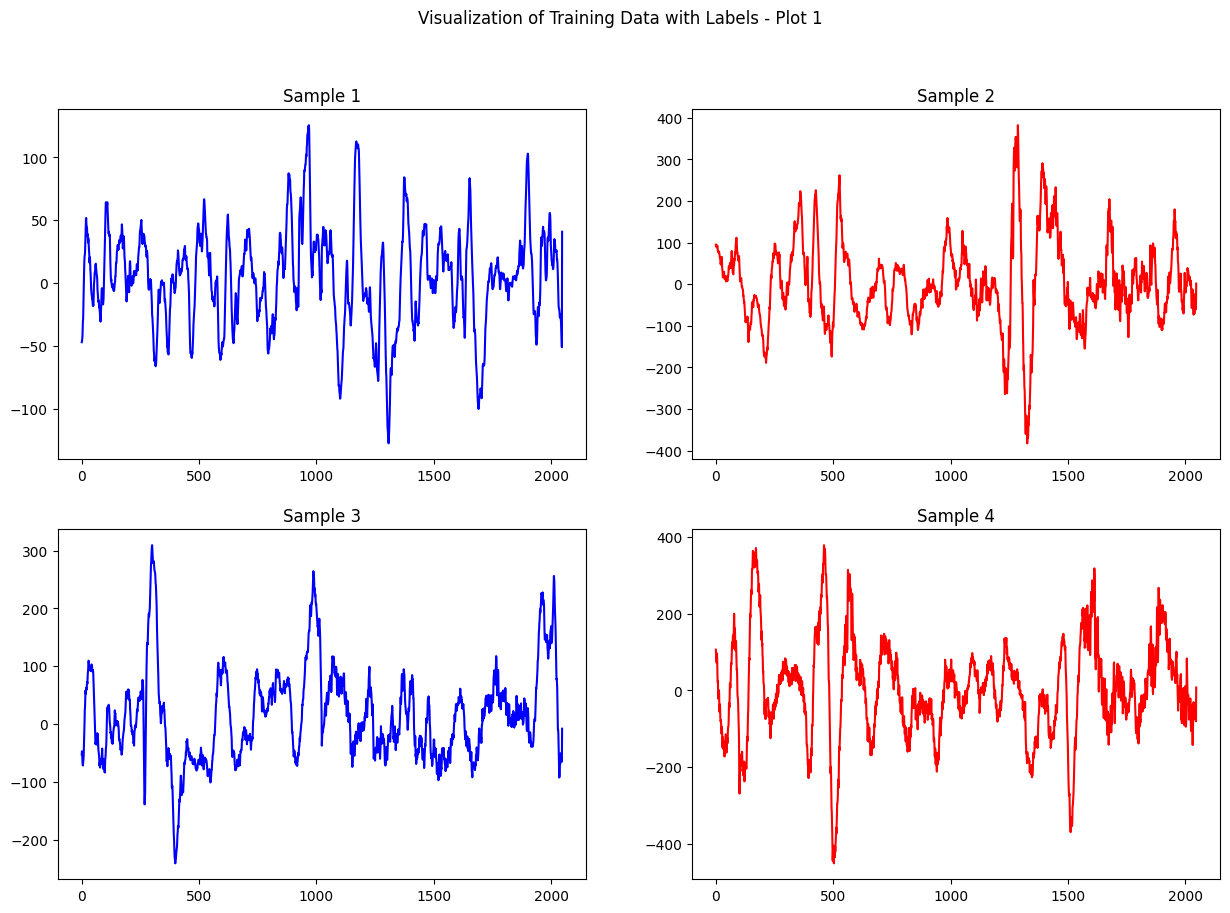

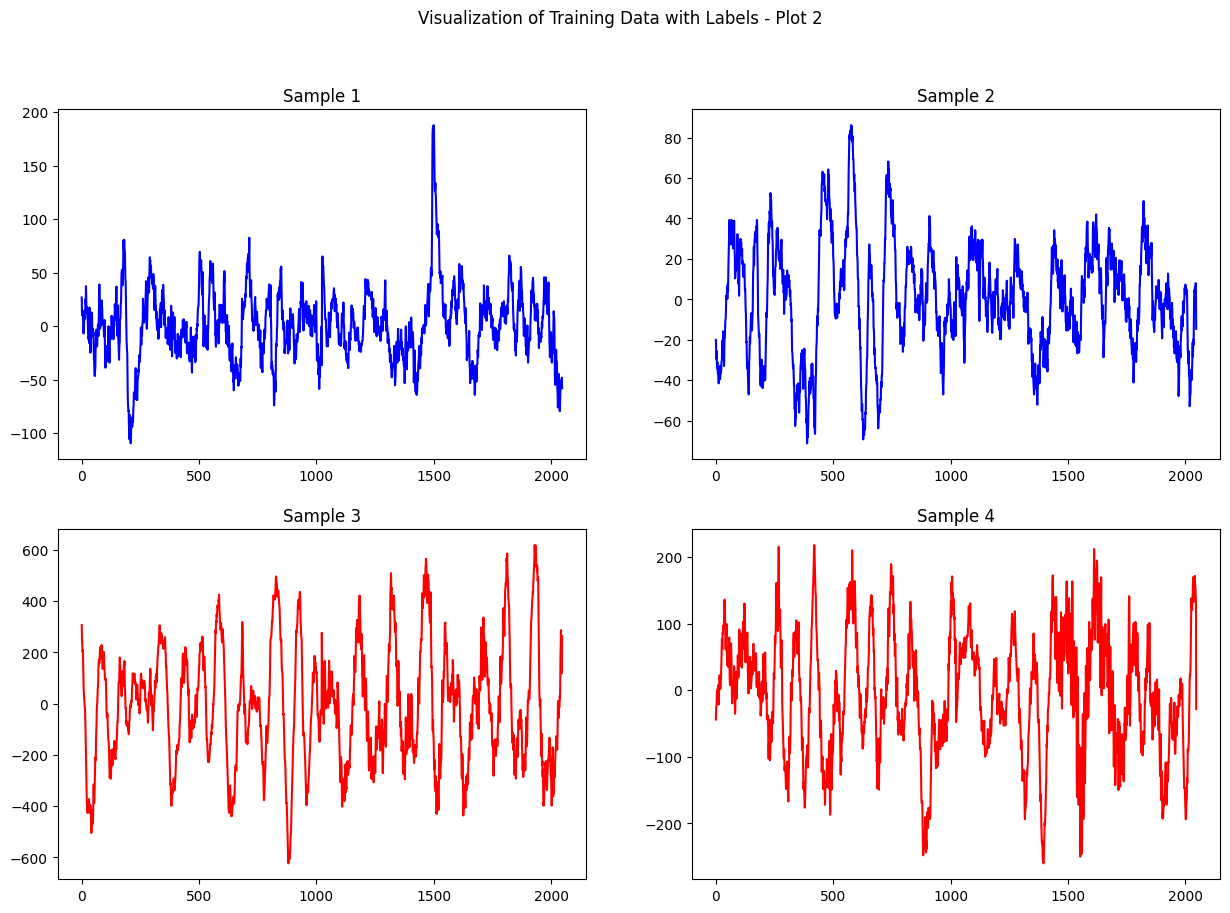

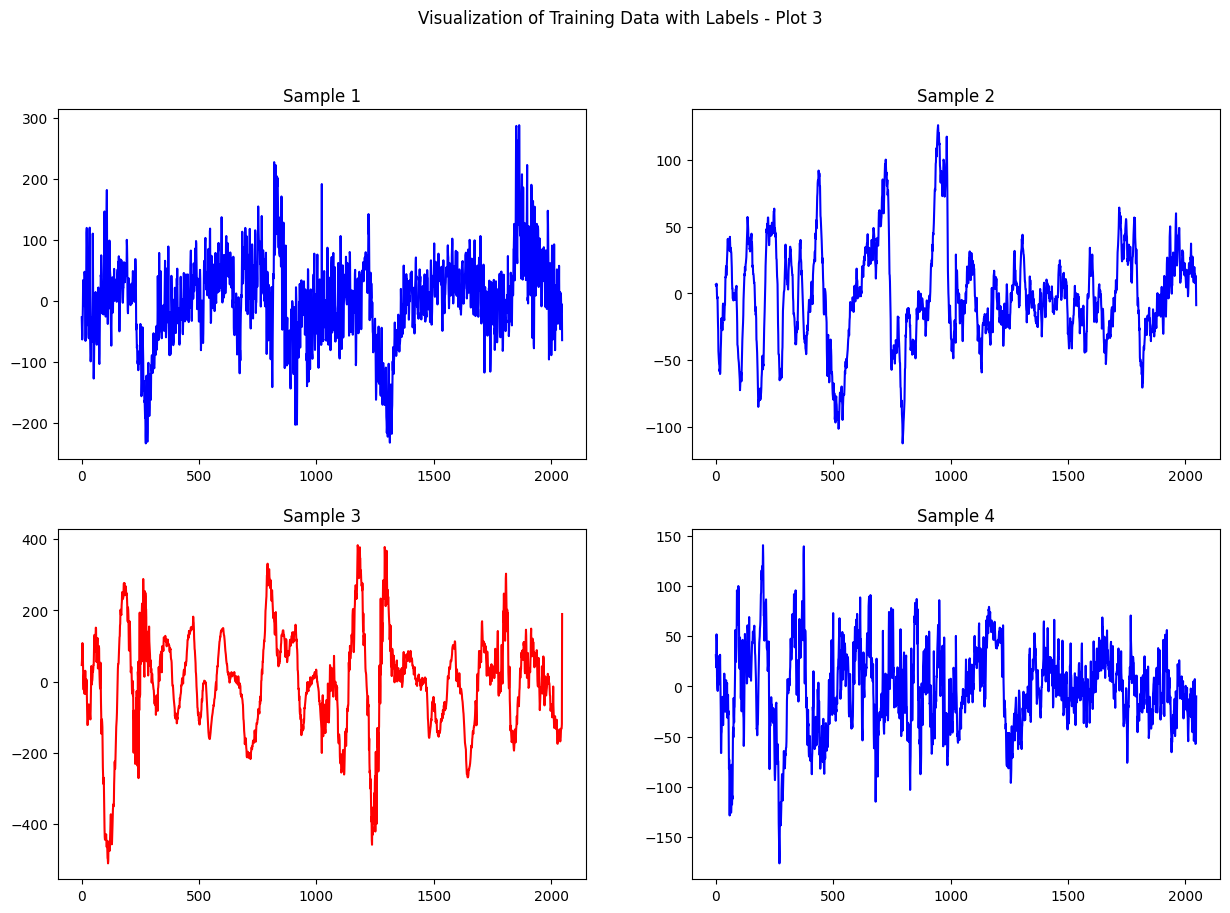

In [5]:
# VISUALIZATION of samples of training data
# RED plots are positive seizures
subset_samples = train_data[:12]
subset_labels = train_labels[:12]

# Calculate the number of plots needed
subplots_per_plot = 4
num_plots = int(np.ceil(len(subset_samples) / subplots_per_plot))

# Plot each set of 4 samples in separate plots, with different colors for each class
for plot_num in range(num_plots):
    start_idx = plot_num * subplots_per_plot
    end_idx = (plot_num + 1) * subplots_per_plot
    current_subset = subset_samples[start_idx:end_idx]
    current_labels = subset_labels[start_idx:end_idx]
    plt.figure(figsize=(15, 10))
    for i, (sample, label) in enumerate(zip(current_subset, current_labels)):
        plt.subplot(2, 2, i+1)  # Adjust the subplot layout based on the number of samples
        plt.plot(sample, label=f'Label: {int(label)}', color='blue' if label == 0 else 'red')
        plt.title(f'Sample {i+1}')

    plt.suptitle(f'Visualization of Training Data with Labels - Plot {plot_num+1}')
    plt.show()


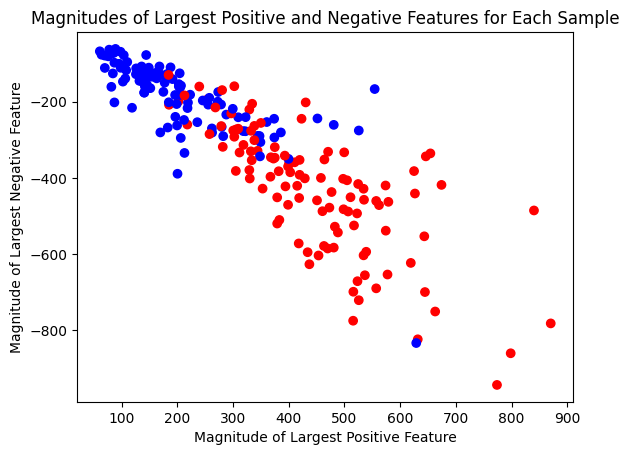

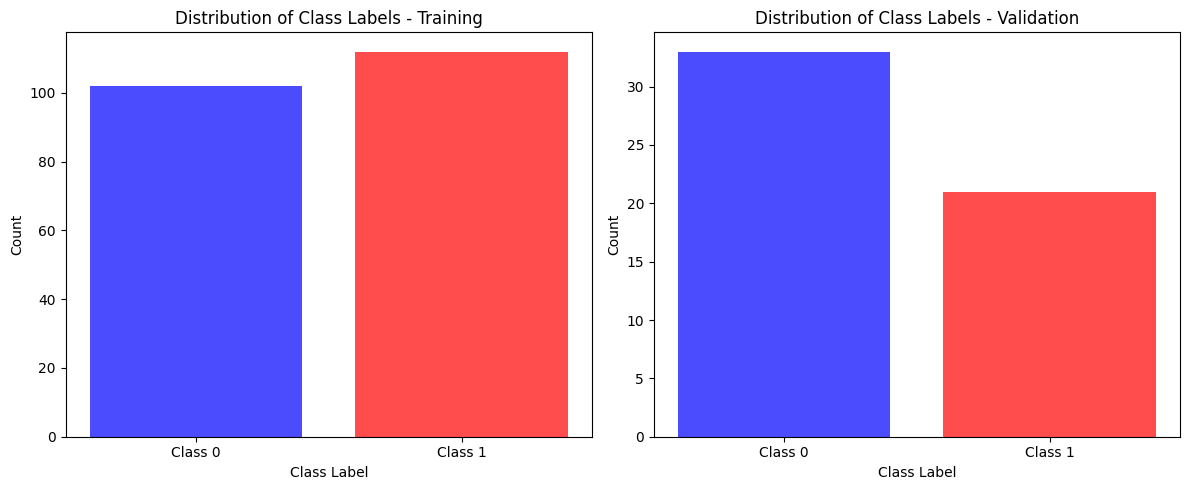

In [6]:
# Function to calculate magnitude of the largest positive and negative feature for each sample
def calculate_magnitudes(data):
    positive_magnitudes = []
    negative_magnitudes = []
    for sample in data:
        # Get the indices of positive and negative features
        positive_indices = np.where(sample > 0)
        negative_indices = np.where(sample < 0)
        if len(positive_indices[0]) > 0:
            # Get the magnitude of the largest positive feature
            positive_magnitude = np.max(sample[positive_indices])
            positive_magnitudes.append(positive_magnitude)
        else:
            positive_magnitudes.append(0)

        if len(negative_indices[0]) > 0:
            # Get the magnitude of the largest negative feature
            negative_magnitude = np.min(sample[negative_indices])
            negative_magnitudes.append(negative_magnitude)
        else:
            negative_magnitudes.append(0)

    return positive_magnitudes, negative_magnitudes

# Calculate magnitudes for the training data
positive_magnitudes, negative_magnitudes = calculate_magnitudes(train_data)

# Plot the magnitudes in a 2D plot with different colors for each label
colors = ['blue' if label == 0 else 'red' for label in train_labels]
plt.scatter(positive_magnitudes, negative_magnitudes, c=colors)
plt.xlabel('Magnitude of Largest Positive Feature')
plt.ylabel('Magnitude of Largest Negative Feature')
plt.title('Magnitudes of Largest Positive and Negative Features for Each Sample')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the distribution of class labels for the training dataset
unique_classes_train, class_counts_train = np.unique(train_labels, return_counts=True)
axes[0].bar(unique_classes_train, class_counts_train, color=['blue', 'red'], alpha=0.7)
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Class Labels - Training')
axes[0].set_xticks(unique_classes_train)
axes[0].set_xticklabels(['Class 0', 'Class 1'])

# Plot the distribution of class labels for the validation dataset
unique_classes_valid, class_counts_valid = np.unique(validation_labels, return_counts=True)
axes[1].bar(unique_classes_valid, class_counts_valid, color=['blue', 'red'], alpha=0.7)
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Class Labels - Validation')
axes[1].set_xticks(unique_classes_valid)
axes[1].set_xticklabels(['Class 0', 'Class 1'])

plt.tight_layout()
plt.show()

## B: Model training for FC-NN
#### Apply the fully-connected neural network the training dataset.


Hint: You should use K.layers.[name_of_layer] to import the layers. Use at least one Dense layer and one Dropout layer. Change values and/or activation functions to get the best result. Don't forget to add input shape for the first layer.

In [7]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(2048,)),  
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.6),  
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dropout(0.6),  
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.6), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid')  # Sigmoid since binary classifucation
])

#### Compile the neural network. You should set optimizar and loss.

In [8]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

#### Fit the neural network using train and validation sets. You can use callback for early stopping or any other method to avoid overfitting. You should set batch size and number of epochs.

In [9]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, start_from_epoch=100)
history_1 = model.fit(normalized_data_train, train_labels, validation_data=(normalized_data_val, validation_labels), batch_size=20, epochs=200)

Epoch 1/200
11/11 [==============================] - 2s 35ms/step - loss: 1.0380 - accuracy: 0.5607 - val_loss: 0.6957 - val_accuracy: 0.3704
Epoch 2/200
11/11 [==============================] - 0s 10ms/step - loss: 1.4925 - accuracy: 0.5093 - val_loss: 0.6719 - val_accuracy: 0.4630
Epoch 3/200
11/11 [==============================] - 0s 9ms/step - loss: 1.3097 - accuracy: 0.5421 - val_loss: 0.6534 - val_accuracy: 0.4815
Epoch 4/200
11/11 [==============================] - 0s 9ms/step - loss: 1.1710 - accuracy: 0.4720 - val_loss: 0.6528 - val_accuracy: 0.5000
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 1.1829 - accuracy: 0.5280 - val_loss: 0.6644 - val_accuracy: 0.6111
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 1.1458 - accuracy: 0.5374 - val_loss: 0.6752 - val_accuracy: 0.5926
Epoch 7/200
11/11 [==============================] - 0s 9ms/step - loss: 1.1426 - accuracy: 0.4860 - val_loss: 0.6838 - val_accuracy: 0.5926
Epoch 8/200

#### Plot the learning curves.

We observed converging but unstable accuracy in training but not in validation. We came to the conclusion that we needed a better model such as a CNN.

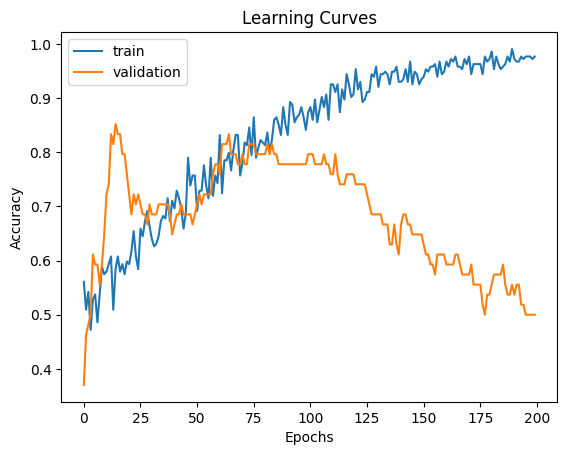

In [10]:
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history_1.history['accuracy'], label='train')
plt.plot(history_1.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

#### For validation data, plot the ROC curve. Calculate and report AUC score.

Hint: You should use **predict** function to predict the labels. Then from **metrics** module, call functions to calculate false positive rate, true positive rate and AUC score. You need rates to create the ROC curve.

Try to analyze the ROC curve. What does AUC score mean?

The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes. An AUC score of 1 means the classifier can perfectly distinguish between all the Positive and the Negative class points.

2/2 [==============================] - 0s 4ms/step
0.7186147186147186


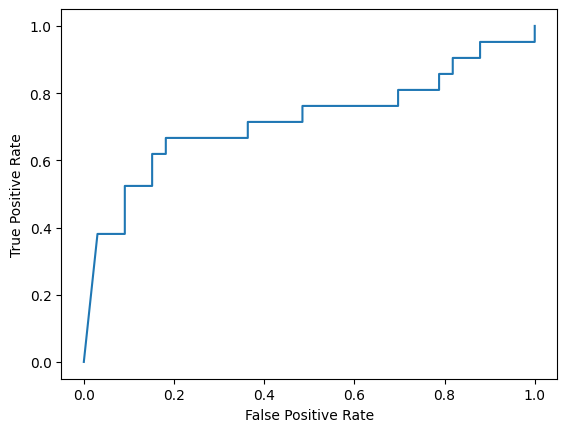

In [11]:
predicted_labels_val_1 = model.predict(normalized_data_val)
fpr_1, tpr_1, _ = metrics.roc_curve(validation_labels, predicted_labels_val_1)
auc_1 = metrics.roc_auc_score(validation_labels, predicted_labels_val_1)
print(auc_1)

#create ROC curve
plt.plot(fpr_1,tpr_1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Predict labels of test dataset.

In [12]:
predicted_labels_test_1 = model.predict(normalized_data_test)
Q1 = (predicted_labels_test_1 >= 0.5).astype(int)

7/7 [==============================] - 0s 2ms/step


## C: Model training for CNN

Build a CNN that can achieve good generalization performance.

#### Reshape datasets to be compatible with the convolution layer in a CNN.

In [13]:
#Datasform 1
train_data_cnn_1 = train_data.reshape(214, 2, 1024, 1)
validation_data_cnn_1 = validation_data.reshape(54, 2, 1024, 1)
test_data_cnn_1 = test_data.reshape(200, 2, 1024, 1)
input_shape_1 = (2, 1024, 1)
print("Shape of dataform 1: ", np.shape(test_data_cnn_1))

#Dataform 2
train_data_cnn_2 = train_data.reshape(214, 4, 512, 1)
validation_data_cnn_2 = validation_data.reshape(54, 4, 512, 1)
test_data_cnn_2 = test_data.reshape(200, 4, 512, 1)
input_shape_2 = (4, 512, 1)
print("Shape of dataform 2: ", np.shape(test_data_cnn_2))

#Dataform 3
train_data_cnn_3 = train_data.reshape(214, 16, 128, 1)
validation_data_cnn_3 = validation_data.reshape(54, 16, 128, 1)
test_data_cnn_3 = test_data.reshape(200, 16, 128, 1)
input_shape_3 = (16, 128, 1)
print("Shape of dataform 3: ", np.shape( test_data_cnn_3))

#Dataform 4
train_data_cnn_4 = train_data.reshape(214, 16, 128)
validation_data_cnn_4 = validation_data.reshape(54, 16, 128)
test_data_cnn_4 = test_data.reshape(200, 16, 128)
input_shape_4 = (16, 128)
print("Shape of dataform 4: ", np.shape( test_data_cnn_4))

#Datasform 5, The final version
train_data_cnn_5 = train_data.reshape(214, 1024, 2)
validation_data_cnn_5 = validation_data.reshape(54, 1024, 2)
test_data_cnn_5 = test_data.reshape(200, 1024, 2)
input_shape_5 = (1024,2)
print("Shape of dataform 5 (after discussion with the professor): ", np.shape(test_data_cnn_5))

Shape of dataform 1:  (200, 2, 1024, 1)
Shape of dataform 2:  (200, 4, 512, 1)
Shape of dataform 3:  (200, 16, 128, 1)
Shape of dataform 4:  (200, 16, 128)
Shape of dataform 5 (after discussion with the professor):  (200, 1024, 2)


#### Apply the convolutional neural network from Keras to the training dataset.


Hint: You should use K.layers.[name_of_layer] to import the layers. Use at least one Convolutional, one MaxPooling, and one Dropout layer. Change values and/or activation functions to get the best result. Don't forget to add input shape for the first layer.

In [14]:
# A first model, with dataform 1
model = keras.models.Sequential([
    keras.layers.Conv2D(4, (4, 1), activation= 'relu', padding='same', strides=(2,1), input_shape=input_shape_1),
    keras.layers.MaxPooling2D((1,4)),
    keras.layers.Conv2D(4, (4, 1), activation= 'relu', padding='same'),
    keras.layers.MaxPooling2D((1,4)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

# A second model, with dataform 3
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(8, (4,4), activation='relu', padding='same', strides=(2, 2), input_shape=input_shape_3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(4, (2,2), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(1, activation='sigmoid'),
])

# A third model, with dataform 3
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(4,(2,8), activation= 'relu', padding='same', strides=(2,4), input_shape=input_shape_3),
    keras.layers.MaxPooling2D((1,4), strides=(1,4)),
    keras.layers.Conv2D(4, (4, 4), activation= 'relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

# A fourth model, with dataform 3
model_4 = keras.models.Sequential([
    keras.layers.Conv2D(4,(2,2), activation= 'relu', padding='same', strides=(2,2), input_shape=input_shape_3),
    keras.layers.MaxPooling2D((1,4), strides=(1,4)),
    keras.layers.Conv2D(4, (4, 4), activation= 'relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

# The final model, now with Conv1D and the dataform 4
model_5 = keras.models.Sequential()

# Add the first convolutional layer
model_5.add(keras.layers.Conv1D(filters=8, kernel_size=4, activation='relu', input_shape=input_shape_5))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.MaxPooling1D(pool_size=2))
model_5.add(keras.layers.Dropout(0.25))

# Add a second convolutional layer
model_5.add(keras.layers.Conv1D(filters=8, kernel_size=2, activation='relu'))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.MaxPooling1D(pool_size=2))
model_5.add(keras.layers.Dropout(0.25))

# Flatten the output before feeding it into the fully connected layers
model_5.add(keras.layers.Flatten())

# Fully connected layers
model_5.add(keras.layers.Dense(8, activation='relu'))
model_5.add(keras.layers.Dropout(0.25))

# Output layer
model_5.add(keras.layers.Dense(1, activation='sigmoid'))

#### Compile the neural network. You should set optimizar and loss.

In [15]:
'''model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()
'''

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1021, 8)           72        
                                                                 
 batch_normalization (BatchN  (None, 1021, 8)          32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 510, 8)           0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 510, 8)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 8)            136       
                                                                 
 batch_normalization_1 (Batc  (None, 509, 8)          

#### Fit the neural network using test and validation set. You can use callback for early stopping to avoid overfitting. You should set batch size and number of epochs.

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, start_from_epoch=100)

In [17]:
#history_1 = model_1.fit(train_data_cnn_1, train_labels, validation_data=(validation_data_cnn_1, validation_labels), batch_size=10, epochs=200, verbose=1, callbacks=[early_stopping])
#history_2 = model_2.fit(train_data_cnn_3, train_labels, validation_data=(validation_data_cnn_3, validation_labels), batch_size=10, epochs=200, verbose=1, callbacks=[early_stopping])
#history_3 = model_3.fit(train_data_cnn_3, train_labels, validation_data=(validation_data_cnn_3, validation_labels), batch_size=10, epochs=200, verbose=1, callbacks=[early_stopping])
#history_4 = model_4.fit(train_data_cnn_3, train_labels, validation_data=(validation_data_cnn_3, validation_labels), batch_size=10, epochs=200, verbose=1, callbacks=[early_stopping])

In [18]:
history_5 = model_5.fit(train_data_cnn_5, train_labels, validation_data=(validation_data_cnn_5, validation_labels), batch_size=32, epochs=200, verbose=1, callbacks=[early_stopping])

Epoch 1/200
7/7 [==============================] - 3s 74ms/step - loss: 0.5454 - accuracy: 0.7243 - val_loss: 7.8513 - val_accuracy: 0.3889
Epoch 2/200
7/7 [==============================] - 0s 29ms/step - loss: 0.4037 - accuracy: 0.8411 - val_loss: 5.8602 - val_accuracy: 0.3889
Epoch 3/200
7/7 [==============================] - 0s 29ms/step - loss: 0.2976 - accuracy: 0.8972 - val_loss: 4.4238 - val_accuracy: 0.3889
Epoch 4/200
7/7 [==============================] - 0s 29ms/step - loss: 0.3121 - accuracy: 0.8738 - val_loss: 3.1755 - val_accuracy: 0.3889
Epoch 5/200
7/7 [==============================] - 0s 30ms/step - loss: 0.2074 - accuracy: 0.9252 - val_loss: 2.9253 - val_accuracy: 0.3889
Epoch 6/200
7/7 [==============================] - 0s 30ms/step - loss: 0.1956 - accuracy: 0.9299 - val_loss: 2.8832 - val_accuracy: 0.4074
Epoch 7/200
7/7 [==============================] - 0s 29ms/step - loss: 0.2014 - accuracy: 0.8925 - val_loss: 2.7581 - val_accuracy: 0.4259
Epoch 8/200
7/7 [===

#### Plot the learning curves.

Try to analyze the curves. Find their differences with the previous learning curves.

Model:  1


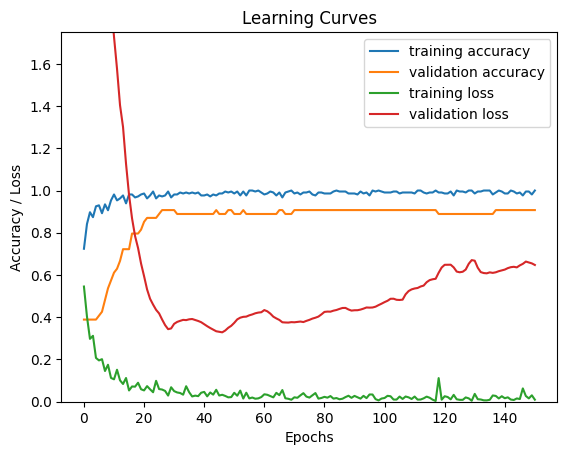

In [19]:
histories = [history_5]
for i,history in enumerate(histories):
    print("Model: ", i+1)
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.ylim(0, 1.75)
    plt.show()

#### For validation data, plot the ROC curve. Calculate and report AUC score.

Hint: You should use **predict** function to predict the labels. Then from **metrics** module, call functions to calculate false positive rate, true positive rate and AUC score. You need rates to create the ROC curve.

Is AUC score higher or lower? Why?

2/2 [==============================] - 0s 8ms/step


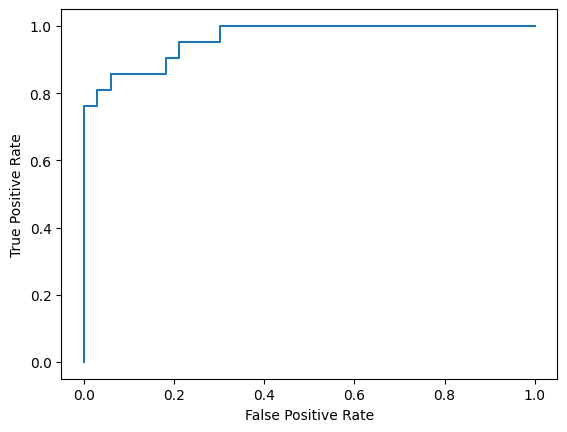

In [20]:
predicted_labels_val_2 = model_5.predict(validation_data_cnn_5)

fpr_2, tpr_2, _ = metrics.roc_curve(validation_labels, predicted_labels_val_2)
auc_2 = metrics.roc_auc_score(validation_labels, predicted_labels_val_2)

#create ROC curve
plt.plot(fpr_2,tpr_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Predict labels for test dataset.

In [21]:
predicted_labels_test_2 = model_5.predict(test_data_cnn_5)
print(np.shape(predicted_labels_test_2))
Q2 = (predicted_labels_test_2 >= 0.5).astype(int)

7/7 [==============================] - 0s 6ms/step
(200, 1)


#### Collect your solutions.

In [22]:
submission_array = Q2.flatten() # Due to my model, flattening is needed.

x = [i for i in range(1,len(submission_array)+1)]
d = {'Id':x,'Category': submission_array}
df = pd.DataFrame(data=d)
print(df)
file_name = 'submission.csv'
df.to_csv(file_name, sep=',',index=False)

      Id  Category
0      1         1
1      2         0
2      3         0
3      4         0
4      5         0
..   ...       ...
195  196         0
196  197         0
197  198         0
198  199         1
199  200         1

[200 rows x 2 columns]
